# Exploring the datasets

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import numpy as np

## Preliminary and general analysis of train part

In [3]:
dataset_folder = ['.\\datasets\\CICDDoS2019\\original\\train', '.\\datasets\\CICDDoS2019\\original\\test']
mem_limit = 1_000_000

In [5]:
def serch_csvs_in_folder(paths: list):
    csv_files = []
    for p in paths:
        for dirname, _, filenames in os.walk(p):
            for filename in filenames:
                csv_file = os.path.join(dirname, filename)
                csv_files.append(csv_file)
    
    return csv_files

In [24]:
csv_files=serch_csvs_in_folder(dataset_folder)
print('Found', len(csv_files), 'files!')
csv_files

Found 18 files!


['.\\datasets\\CICDDoS2019\\original\\train\\DrDoS_DNS.csv',
 '.\\datasets\\CICDDoS2019\\original\\train\\DrDoS_LDAP.csv',
 '.\\datasets\\CICDDoS2019\\original\\train\\DrDoS_MSSQL.csv',
 '.\\datasets\\CICDDoS2019\\original\\train\\DrDoS_NetBIOS.csv',
 '.\\datasets\\CICDDoS2019\\original\\train\\DrDoS_NTP.csv',
 '.\\datasets\\CICDDoS2019\\original\\train\\DrDoS_SNMP.csv',
 '.\\datasets\\CICDDoS2019\\original\\train\\DrDoS_SSDP.csv',
 '.\\datasets\\CICDDoS2019\\original\\train\\DrDoS_UDP.csv',
 '.\\datasets\\CICDDoS2019\\original\\train\\Syn.csv',
 '.\\datasets\\CICDDoS2019\\original\\train\\TFTP.csv',
 '.\\datasets\\CICDDoS2019\\original\\train\\UDPLag.csv',
 '.\\datasets\\CICDDoS2019\\original\\test\\LDAP.csv',
 '.\\datasets\\CICDDoS2019\\original\\test\\MSSQL.csv',
 '.\\datasets\\CICDDoS2019\\original\\test\\NetBIOS.csv',
 '.\\datasets\\CICDDoS2019\\original\\test\\Portmap.csv',
 '.\\datasets\\CICDDoS2019\\original\\test\\Syn.csv',
 '.\\datasets\\CICDDoS2019\\original\\test\\UDP.csv',

In [26]:
sizes = [str(os.path.getsize(file)/(2.0**30)) + " GB" for file in csv_files]
print(sizes)

['1.9867978505790234 GB', '0.8543043183162808 GB', '1.7594376169145107 GB', '1.5809012847021222 GB', '0.6007110755890608 GB', '2.02337262686342 GB', '1.1666549546644092 GB', '1.4026084644719958 GB', '0.5935431709513068 GB', '8.663172940723598 GB', '0.14711988158524036 GB', '0.8115534838289022 GB', '2.2223454229533672 GB', '1.321051367558539 GB', '0.07321227341890335 GB', '1.7484389850869775 GB', '1.6696725953370333 GB', '0.29783082474023104 GB']


In [27]:
def fix_data(chunk):
    c = chunk.copy() #duplicate chunk to edit it

    c.columns = c.columns.str.strip() #strip spaces from col names

    #drop na and +-inf values
    c.replace([np.inf, -np.inf], np.nan, inplace=True)
    c.dropna(inplace=True)

    c = c[c['Label'] != 'WebDDoS'] #drop webddos class
    c = c[c['Label'] != 'Portmap'] #drop portmap class

    #drop useless cols
    c.drop(['Unnamed: 0','Timestamp','Source Port','Source IP','SimillarHTTP',
    'Protocol','Flow ID','Destination IP'], axis=1, inplace=True)

    #beautify labels (cut and rename some stuff)
    c['Label']=c['Label'].str.replace('DrDoS_', '')
    c['Label']=c['Label'].str.replace('UDP-lag', 'UDPLag')

    return c

In [28]:
only_header = pd.read_csv(csv_files[0], nrows=0)
only_header.columns=only_header.columns.str.strip()
only_header.drop(['Unnamed: 0','Timestamp','Source Port','Source IP','SimillarHTTP',
'Protocol','Flow ID','Destination IP'], axis=1, inplace=True)
only_header.to_csv('.\\datasets\\CICDDoS2019\\CORRECT_CUT\\unified_jumbo.csv', mode='w', index=False, header=True) #copy only header to final jumbo csv

for ds in csv_files: #for every dataset file
    with pd.read_csv(ds, chunksize=mem_limit) as reader: #that has to be processed in chunks
        for chunk in reader: #for every chunk
            c = fix_data(chunk) #tidy up the dataset
            c.to_csv('.\\datasets\\CICDDoS2019\\CORRECT_CUT\\unified_jumbo.csv', mode='a', index=False, header=False)


C:\Users\MAX\AppData\Local\Temp\ipykernel_24696\1396463340.py:9: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader: #for every chunk
C:\Users\MAX\AppData\Local\Temp\ipykernel_24696\1396463340.py:9: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader: #for every chunk
C:\Users\MAX\AppData\Local\Temp\ipykernel_24696\1396463340.py:9: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader: #for every chunk
C:\Users\MAX\AppData\Local\Temp\ipykernel_24696\1396463340.py:9: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in reader: #for every chunk
C:\Users\MAX\AppData\Local\Temp\ipykernel_24696\1396463340.py:9: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  for chun

In [29]:
def get_class_distrib(datasets):
    classes_distr = {}
    for ds in datasets:
        with pd.read_csv(ds, chunksize=mem_limit) as reader: #that has to be processed in chunks
            for c in reader:
                labels_count = c['Label'].value_counts()

                for class_, count in labels_count.items():
                    if class_ in classes_distr.keys():
                        classes_distr[class_] += count
                    else:
                        classes_distr[class_] = count

    return classes_distr

In [30]:
classes_distr_precut = get_class_distrib(['.\\datasets\\CICDDoS2019\\CORRECT_CUT\\unified_jumbo.csv'])
print(classes_distr_precut)
%store classes_distr_precut

{'DNS': 4908665, 'BENIGN': 112731, 'LDAP': 4013439, 'MSSQL': 9980517, 'NetBIOS': 7479340, 'NTP': 1195690, 'SNMP': 5149261, 'SSDP': 2568569, 'UDP': 6884300, 'Syn': 5938816, 'TFTP': 19515971, 'UDPLag': 331952}
Stored 'classes_distr_precut' (dict)


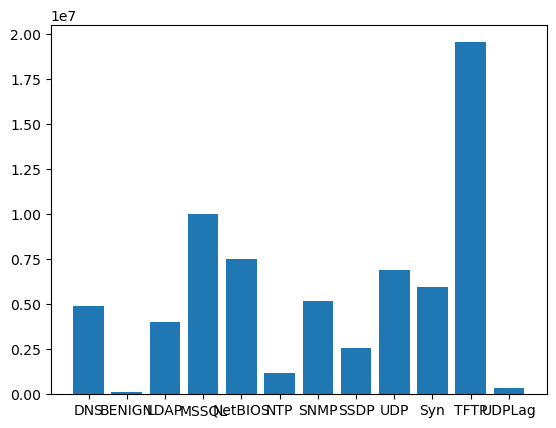

In [10]:
%store -r classes_distr_precut
plt.bar(classes_distr_precut.keys(), classes_distr_precut.values())
plt.show()

In [11]:
min_val = min(classes_distr_precut.values())
smallest_class = [k for k, v in classes_distr_precut.items() if v == min_val][0]
print('The class that has less items is', smallest_class, 'with', min_val, 'items.')

The class that has less items is BENIGN with 112731 items.


In [12]:
def init_one_class_dataset_storage(where, class_, cols):
    class_dir = os.path.join(where, class_)
    os.mkdir(class_dir)

    only_header=pd.DataFrame(columns=cols)
    only_header.to_csv(os.path.join(class_dir, class_+'.csv'), mode='w', index=False, header=True)

    return os.path.join(class_dir, class_+'.csv')

In [13]:
def check_if_class_exists(classes_folder, class_):
    class_dir = os.path.join(classes_folder, class_)
    if os.path.exists(class_dir):
        return True, os.path.join(class_dir, class_+'.csv')
    else:
        return False, ''

In [14]:
def extract_class_from_chunk(chunk, class_):
    return chunk[chunk['Label'] == class_]

In [15]:
def separate_classes(datasets):
    for ds in datasets:
        with pd.read_csv(ds, chunksize=mem_limit) as reader:
            for c in reader:
                classes_in_this_chunk = c['Label'].unique()

                for unique_label in classes_in_this_chunk:
                    to_save = extract_class_from_chunk(c, unique_label)

                    response, csv_path = check_if_class_exists('.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes', unique_label)
                    if not response:
                        csv_path = init_one_class_dataset_storage('.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes', unique_label, to_save.columns.tolist()) 

                    to_save.to_csv(csv_path, mode='a', index=False, header=False)

In [40]:
separate_classes(['.\\datasets\\CICDDoS2019\\CORRECT_CUT\\unified_jumbo.csv'])

In [25]:
import random

def fair_cut(cut_to, one_class_csvs, classes_distr):

    only_header = pd.read_csv(one_class_csvs[0], nrows=0)
    only_header.to_csv('.\\datasets\\CICDDoS2019\\CORRECT_CUT\\fair_cut.csv', mode='w', index=False, header=True)

    for path in one_class_csvs:
        class_name = os.path.dirname(path).split('\\')[-1]

        rows_to_keep = random.sample(range(classes_distr[class_name]), cut_to)
        rows_to_keep.sort()
    
        with pd.read_csv(path, chunksize=mem_limit) as reader:
            for c in reader:
                    to_save = c.copy()
                    to_save = to_save[to_save.index.isin(rows_to_keep)]

                    to_save.to_csv('.\\datasets\\CICDDoS2019\\CORRECT_CUT\\fair_cut.csv', mode='a', index=False, header=False)

In [26]:
fair_cut(min_val, serch_csvs_in_folder(['.\\datasets\\CICDDoS2019\\CORRECT_CUT\\classes']), classes_distr_precut)

In [31]:
classes_distr_postcut = get_class_distrib(['.\\datasets\\CICDDoS2019\\CORRECT_CUT\\fair_cut.csv'])
print(classes_distr_postcut)
%store classes_distr_postcut

{'BENIGN': 112731, 'DNS': 112731, 'LDAP': 112731, 'MSSQL': 112731, 'NetBIOS': 112731, 'NTP': 112731, 'SNMP': 112731, 'SSDP': 112731, 'Syn': 112731, 'TFTP': 112731, 'UDP': 112731, 'UDPLag': 112731}
Stored 'classes_distr_postcut' (dict)


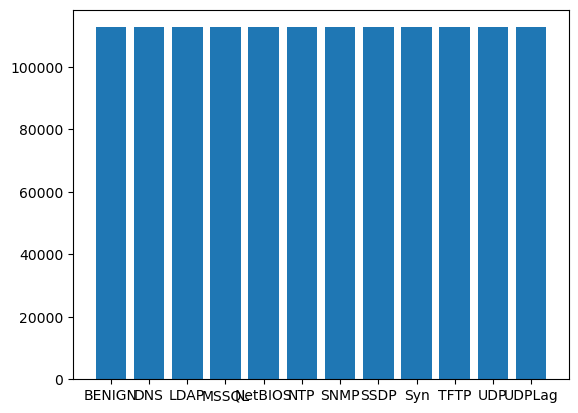

In [32]:
%store -r classes_distr_postcut
plt.bar(classes_distr_postcut.keys(), classes_distr_postcut.values())
plt.show()

In [34]:
sizes = str(os.path.getsize('.\\datasets\\CICDDoS2019\\CORRECT_CUT\\fair_cut.csv')/(2.0**30)) + " GB"
print('Resulting balanced dataset:', sizes)

Resulting balanced dataset: 0.43746340088546276 GB
